#Iterative Refinement Implementaion

In [1]:
pip install -qU langchain_google_genai --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.1 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
import os
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
# os.environ["HUGGINGFACEHUB_API_TOKEN"] = userdata.get('HUGGINGFACEHUB_API_TOKEN')

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI
# from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint

def load_llm(model="gemini-1.5-flash"):

  if model == "gemini-1.5-pro":
    llm = ChatGoogleGenerativeAI(
        model="gemini-1.5-pro",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2)
    return llm
  elif model == "gemini-1.5-flash":
    llm = ChatGoogleGenerativeAI(
        model="gemini-1.5-flash",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2)
    return llm
  else:
    raise ValueError("Invalid model name")

In [4]:
llm = load_llm()

In [5]:
from langchain_core.documents import Document

documents = [
    Document(page_content="Apples are red", metadata={"title": "apple_book"}),
    Document(page_content="Blueberries are blue", metadata={"title": "blueberry_book"}),
    Document(page_content="Bananas are yelow", metadata={"title": "banana_book"}),
]

In [6]:
pip install -qU langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 6.6 MB/s eta 0:00:00


In [7]:
import operator
from typing import List, Literal, TypedDict

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

# Initial summary
summarize_prompt = ChatPromptTemplate(
    [
        ("human", "Write a concise summary of the following: {context}"),
    ]
)
initial_summary_chain = summarize_prompt | llm | StrOutputParser()

# Refining the summary with new docs
refine_template = """
Produce a final summary.

Existing summary up to this point:
{existing_answer}

New context:
------------
{context}
------------

Given the new context, refine the original summary.
"""
refine_prompt = ChatPromptTemplate([("human", refine_template)])

refine_summary_chain = refine_prompt | llm | StrOutputParser()


# We will define the state of the graph to hold the document
# contents and summary. We also include an index to keep track
# of our position in the sequence of documents.
class State(TypedDict):
    contents: List[str]
    index: int
    summary: str


# We define functions for each node, including a node that generates
# the initial summary:
async def generate_initial_summary(state: State, config: RunnableConfig):
    summary = await initial_summary_chain.ainvoke(
        state["contents"][0],
        config,
    )
    return {"summary": summary, "index": 1}


# And a node that refines the summary based on the next document
async def refine_summary(state: State, config: RunnableConfig):
    content = state["contents"][state["index"]]
    summary = await refine_summary_chain.ainvoke(
        {"existing_answer": state["summary"], "context": content},
        config,
    )

    return {"summary": summary, "index": state["index"] + 1}


# Here we implement logic to either exit the application or refine
# the summary.
def should_refine(state: State) -> Literal["refine_summary", END]:
    if state["index"] >= len(state["contents"]):
        return END
    else:
        return "refine_summary"


graph = StateGraph(State)
graph.add_node("generate_initial_summary", generate_initial_summary)
graph.add_node("refine_summary", refine_summary)

graph.add_edge(START, "generate_initial_summary")
graph.add_conditional_edges("generate_initial_summary", should_refine)
graph.add_conditional_edges("refine_summary", should_refine)
app = graph.compile()

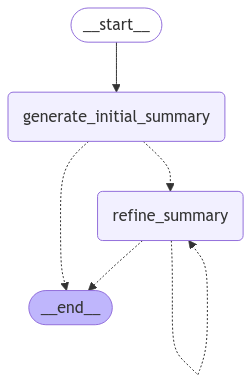

In [8]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [9]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in documents]},
    stream_mode="values",
):
    if summary := step.get("summary"):
        print(summary)



async def summarize_documents(user_content: List[str]):
    summary = None
    async for step in app.astream(
        {"contents": user_content}, stream_mode="values"
    ):
        if step.get("summary"):
            summary = step["summary"]
    return summary

user_content = [
    "Artificial Intelligence (AI) is a field of computer science that focuses on creating systems capable of performing tasks that usually require human intelligence.",
    "Examples of these tasks include learning, reasoning, problem-solving, perception, and language understanding.",
    "Machine Learning, a subset of AI, involves teaching machines to learn from data and improve over time without being explicitly programmed.",
    "Deep Learning, a branch of Machine Learning, uses neural networks with many layers to analyze large amounts of data efficiently."
]
summary = await summarize_documents(user_content)
print(summary)

Apples can be red.

Apples can be red, and blueberries are blue.

Apples are red, blueberries are blue, and bananas are yellow.

Artificial intelligence (AI) is a branch of computer science focused on creating systems that mimic human intelligence, encompassing learning, reasoning, problem-solving, perception, and language understanding.  A crucial element of AI is machine learning, allowing systems to learn from data and improve without explicit programming.  Deep learning, a subfield of machine learning, leverages multi-layered neural networks to efficiently process and analyze vast datasets, significantly enhancing AI capabilities.



#Implementation of Map Reduce

In [10]:
pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.36
    Uninstalling SQLAlchemy-2.0.36:
      Successfully uninstalled SQLAlchemy-2.0.36
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.19
    Uninstalling langchain-core-0.3.19:
      Successfully uninstalled langchain-core-0.3.19
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.7
    Uninstalling langchain-0.3.7:
      Successfully uninstalled langchain-0.3.7


In [11]:
pip install tiktoken --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.7 MB/s eta 0:00:00


In [12]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

split_docs = text_splitter.split_documents(docs)
split_docs = split_docs[0:2]
print(f"Generated {len(split_docs)} documents.")

Generated 2 documents.


In [13]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

map_prompt = ChatPromptTemplate.from_messages(
    [("human", "Write a concise summary of the following:\\n\\n{context}")]
)

map_chain = map_prompt | llm | StrOutputParser()

In [14]:
reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes.
"""

reduce_prompt = ChatPromptTemplate([("human", reduce_template)])

reduce_chain = reduce_prompt | llm | StrOutputParser()

In [15]:
pip install -qU langgraph --quiet

In [16]:
import operator
from typing import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

token_max = 1000


def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)


# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str


# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(TypedDict):
    content: str


# Here we generate a summary, given a document
async def generate_summary(state: SummaryState):
    response = await map_chain.ainvoke(state["content"])
    return {"summaries": [response]}


# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_summaries(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]


def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }


# Add node to collapse summaries
async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, reduce_chain.ainvoke))

    return {"collapsed_summaries": results}


# This represents a conditional edge in the graph that determines
# if we should collapse the summaries or not
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


# Here we will generate the final summary
async def generate_final_summary(state: OverallState):
    response = await reduce_chain.ainvoke(state["collapsed_summaries"])
    return {"final_summary": response}


# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# Edges:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()

In [17]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

['generate_summary']
['generate_summary']
['collect_summaries']
['generate_final_summary']


In [18]:
print(step['generate_final_summary']['final_summary'])

Both documents discuss Large Language Model (LLM)-powered autonomous agents, focusing on their key architectural components and capabilities.  These components include planning systems (using methods like Chain of Thought, Tree of Thoughts, and external classical planners), memory systems (short-term and long-term, potentially vector databases), and tool-use systems (interacting with external APIs).  The agents' ability for self-reflection, crucial for improved performance and error correction, is highlighted, with examples like ReAct and Reflexion frameworks.  The overall theme emphasizes the evolution of LLMs beyond simple text generation towards general problem-solving agents.



In [19]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [20]:
pip install -qU langgraph

In [21]:
import operator
from typing import List, Literal, TypedDict

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph
from nltk.tokenize import sent_tokenize
import nest_asyncio
import asyncio


# Initial summary
summarize_prompt = ChatPromptTemplate(
    [
        ("human", "Write a concise summary of the following: {context}"),
    ]
)
initial_summary_chain = summarize_prompt | llm | StrOutputParser()

# Refining the summary with new docs
refine_template = """
Produce a final summary.

Existing summary up to this point:
{existing_answer}

New context:
------------
{context}
------------

Given the new context, refine the original summary.
"""
refine_prompt = ChatPromptTemplate([("human", refine_template)])

refine_summary_chain = refine_prompt | llm | StrOutputParser()


# We will define the state of the graph to hold the document
# contents and summary. We also include an index to keep track
# of our position in the sequence of documents.
class State(TypedDict):
    contents: List[str]
    index: int
    summary: str


# We define functions for each node, including a node that generates
# the initial summary:
async def generate_initial_summary(state: State, config: RunnableConfig):
    summary = await initial_summary_chain.ainvoke(
        state["contents"][0],
        config,
    )
    return {"summary": summary, "index": 1}


# And a node that refines the summary based on the next document
async def refine_summary(state: State, config: RunnableConfig):
    content = state["contents"][state["index"]]
    summary = await refine_summary_chain.ainvoke(
        {"existing_answer": state["summary"], "context": content},
        config,
    )

    return {"summary": summary, "index": state["index"] + 1}


# Here we implement logic to either exit the application or refine
# the summary.
def should_refine(state: State) -> Literal["refine_summary", END]:
    if state["index"] >= len(state["contents"]):
        return END
    else:
        return "refine_summary"


graph = StateGraph(State)
graph.add_node("generate_initial_summary", generate_initial_summary)
graph.add_node("refine_summary", refine_summary)

graph.add_edge(START, "generate_initial_summary")
graph.add_conditional_edges("generate_initial_summary", should_refine)
graph.add_conditional_edges("refine_summary", should_refine)
app = graph.compile()



async def summarize_documents(user_content: List[str]):
    summary = None
    async for step in app.astream(
        {"contents": user_content}, stream_mode="values"
    ):
        if step.get("summary"):
            summary = step["summary"]
    return summary

text = '''The Impact of Technology on Modern Education

In recent years, technology has revolutionized many aspects of our lives, with one of the most significant changes occurring in the field of education. The introduction of digital tools in classrooms, online learning platforms, and mobile applications has drastically transformed how students learn, how teachers deliver instruction, and how parents support their children's education.

One of the most impactful changes has been the introduction of online learning platforms. Platforms like Khan Academy, Coursera, and edX have made it possible for people across the globe to access high-quality education without stepping into a traditional classroom. These platforms offer a range of courses in various fields, often led by experts from top universities, which can be taken at one's own pace. This flexibility has opened up educational opportunities for those who may not have had access otherwise.

Moreover, technology has enabled personalized learning experiences. Adaptive learning technologies, such as DreamBox and Smart Sparrow, use artificial intelligence to assess students' understanding of topics and customize the curriculum accordingly. This way, students can work on the areas they struggle with while advancing at their own speed, making learning more efficient and engaging.

Despite these benefits, the integration of technology in education also brings challenges. Not all students have access to reliable internet or devices, leading to a digital divide. Students from low-income families may struggle to participate fully in online learning or keep up with assignments if they lack adequate resources. Additionally, there's a growing concern about the amount of screen time students are exposed to, which can impact their physical and mental health.

Furthermore, while technology can enhance the learning experience, it cannot replace the value of face-to-face interactions. In-person discussions, group work, and hands-on activities foster social skills and collaboration, which are crucial for holistic development. Teachers and educators must strike a balance between utilizing technology and promoting interpersonal skills in students.

In conclusion, technology has brought substantial advancements to education, making it more accessible and customizable. However, it is essential to address the disparities that come with digital learning and to complement technology with traditional educational methods. The future of education lies in a balanced approach, where technology supports and enhances, rather than replaces, the human elements of teaching and learning.
'''
user_content = sent_tokenize(text)
summary = await summarize_documents(user_content)
print(summary)

ResourceExhausted: 429 Resource has been exhausted (e.g. check quota).